# Build a travel recommendation engine

This notebook contains steps and code to import user transaction *history from PostgresSQL, create hotel and car recommendation engines, and deploy these models to Watson Machine Learning. This notebook runs on Python 3.6 with Apache Spark 2.1.

*<i>The data in this code pattern is fake and does not involve any real purchase events</i>

## Learning Goals

The learning goals of this notebook are:

* Process the PostgresSQL data assets from the Object Storage service into a CSV file
* Load the CSV file into the Object Storage service linked to your Watson Studio
* Use the *k*-means algorithm, which is useful for cluster analysis in data mining, to segment customers leaving within the same time from booking to departure category into clusters for the purpose of finding relevant search results
* Deploy the model to the IBM Watson Machine Learning service in IBM Cloud to create your recommendation application

#### <u>The video example of Bee Travels may provide you insight into the data you will encounter through this code pattern.</u>

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200807213820-0000
KERNEL_ID = c2730154-5ef8-4f1d-ae07-58f6f3102cc0


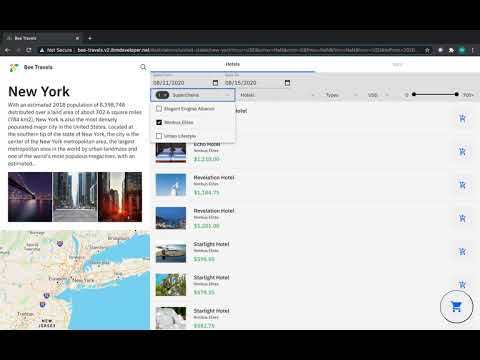

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('mcWI_KIn0sk')

In the demo video, you can see the demo travel site [Bee Travels](http://bee-travels.v2.ibmdeveloper.net/) has hotel and car rental options. Users can filter hotels based on city, superchain, types, and time period of the trip. While car rentals in addition to the those parameters can also filter on body style. Data is aggregated in this notebook by customer ID and group, the amount of days before departure that the customer books the travel service. The group category as a customer identifier ensures that we can cater to the user's needs because users that usually travel a months in advance can now travel a few days in advance can get results, that are not just a month in advance, are based on their current needs. Instead of just grouping based on customer history, we group based on customer history _and_ their travel time from the date of booking. 

## Table of contents

1. [Data Parameters](#dataparameters)<br>
2. [Setup](#setup)<br>
3. [Load and explore data](#load)<br>
4. [Create a KMeans model](#kmeans)<br>
   3.1. [Prepare data](#prepare_data)<br>
   3.2. [Create clusters and define the model](#build_model)<br>
5. [Persist the model](#persist)<br>
6. [Deploy the model to the cloud](#deploy)<br>
   5.1. [Create deployment for the model](#create_deploy)<br>
   5.2. [Test model deployment](#test_deploy)<br>
7. [Create travel recommendations](#create_recomm)<br>
   6.1. [Test travel recommendations model](#test_recomm)<br>
8. [Summary and next steps](#summary)<br>

<a id="dataparameters"></a>
## 1. Data Parameters

#### Car Data Variables

The other model trains on a data set with user transactions of car rentals with the following variables:
* Id: (type string) the customer ID of travelers with new and/or historical purchases
     <br><pre> Ex: b02b9dc9-673b-468f-ba2f-296d88e44429</pre>
* group: (type integer) the number of days before departure that the traveler books the car binned into categories 1-5 

where:


    - Group 1: represents < 3 days in advance    
    - Group 2: represents 3-6 days in advance
    - Group 3: represents 7-14 days in advance
    - Group 4: represents 15-29 days in advance
    - Group 5: represents 30 or greater days in advance
    
- rent-pad, capsule, rentio, chakra, carlux: (type integer) car rental companies, containing 1 or 0 where:

      - 1 represents the rental company was booked during a transaction, for each transaction (row of data) 
          there is only one rental company booking
      - 0 represents the rental companies that were not booked during a transaction
    
* sedan, suv, hatchback, muscle, crossover, convertible, sports: (type integer) car body type, containing 1 or 0 

where:

     - 1 represents the body type purchased, for each transaction (row of data) there is only one body style
         given 1
     - 0 represents the body styles that were not booked during a transaction
    
* basic, luxury, comfort: (type integer) car style, containing 1 or 0 where:

      - 1 represents the style purchased, for each transaction (row of data) there is only one style give 1
      - 0 represents the styles that were not booked during a transaction

#### Hotel Data Variables

The other model trains on a data set with user transactions of car rentals with the following variables:
* Id: (type string) the customer ID of travelers with new and/or historical purchases
     <br><pre> Ex: b02b9dc9-673b-468f-ba2f-296d88e44429</pre>
* group: (type integer) the number of days before departure that the traveler books the hotel binned into categories 1-5 where:
 

where:


    - Group 1: represents < 3 days in advance    
    - Group 2: represents 3-6 days in advance
    - Group 3: represents 7-14 days in advance
    - Group 4: represents 15-29 days in advance
    - Group 5: represents 30 or greater days in advance
    
- nimbus-elites, elegant-enigma-alliance, urban-lifestyle: (type integer) hotel chain companies containing 1 or 0 where:

      - 0 represents the hotel chains that were not booked during a transaction
      - 1 represents the hotel chain was booked during a transaction, for each transaction (row of data) there is only one chain booked
    
* budget, luxury, comfort: (type integer) hotels are labeled by these user priorities, containing 1 or 0 where:

      - 0 represents the priorities that were not booked during a transaction
      - 1 represents the priority booked during a transaction, for each transaction (row of data) there is only 
        one priority selected

<a id="setup"></a>
## 2. Setup


Before you use the sample code in this notebook, you must perform the following setup tasks:

* Understand the data characteristics for each of the two recommendation systems present in this code pattern
* Create a Watson Machine Learning service instance (a free plan is offered) and associate it with your project


We'll be using a few libraries for this exercise:

1. [Watson Machine Learning Client](http://wml-api-pyclient.mybluemix.net/): Client library to work with the Watson Machine Learning service on IBM Cloud. Library available on [pypi](https://pypi.org/project/watson-machine-learning-client/). Service available on [IBM Cloud](https://cloud.ibm.com/catalog/services/machine-learning).
1. [Pixiedust](https://github.com/pixiedust/pixiedust): Python Helper library for Jupyter Notebooks. Available on [pypi](https://pypi.org/project/pixiedust/).
1. [ibmos2spark](https://github.com/ibm-watson-data-lab/ibmos2spark): Facilitates Data I/O between Spark and IBM Object Storage services

In [382]:
!pip install --upgrade ibmos2spark
!pip install --upgrade pixiedust
!pip install --upgrade watson-machine-learning-client

  Using cached https://files.pythonhosted.org/packages/c6/81/1edb24382edef1ca636e87972b2da286b8271a586c728a21f916d3cd76cd/ibmos2spark-1.0.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e4/8d/9e28e9af95739e6d2d2f8d4bef0b3432da40b7c3588fbad4298c1be09e48/geojson-2.5.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a4/63/eaec2bd025ab48c754b55e8819af0f6a69e2b1e187611dd40cbbe101ee7f/Markdown-3.2.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/45/1e/0c169c6a5381e241ba7404532c16a21d86ab872c9bed8bdcd4c423954103/requests-2.24.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/79/37/d420b7fdc9a550bd29b8cfeacff3b38502d9600b09d7dfae9a69e623b891/lxml-4.5.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.o

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [384]:
import pixiedust

In [385]:
pixiedust.optOut() #opt out of Pixie Dust collecting your data

Pixiedust will not collect anonymous install statistics.


##### <a id="load"></a>
## 3. Load and explore data

In this section you will load the CSV data file that contains the car rental transaction history using PixieDust's [`sampleData`](https://pixiedust.github.io/pixiedust/loaddata.html) method:

In [386]:
#loads the data as a CSV from Github as a raw file
sparkDataFrame = pixiedust.sampleData('https://raw.githubusercontent.com/mhrosen/recommendation-code-pattern/master/notebook/data%20assets/cars_csv_uid.csv')



Creating pySpark DataFrame for 'https://raw.githubusercontent.com/mhrosen/recommendation-code-pattern/master/notebook/data%20assets/cars_csv_uid.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://raw.githubusercontent.com/mhrosen/recommendation-code-pattern/master/notebook/data%20assets/cars_csv_uid.csv'


To better examine and visualize the data, run the following cell to view it in a table format. Note that Pixiedust's `display` method can also render data using various chart types, such as pie charts, line graphs, and scatter plots.

In [ ]:
display(sparkDataFrame)

id,group,rent-pad,capsule,rentio,chakra,carlux,sedan,suv,hatchback,muscle,crossover,convertible,sports,basic,premium,luxury
b1dcc4b6-a2e2-4bfb-ad5f-c246b4b59e07,4,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
81448ac0-e002-4958-9a99-b7da63d0ac54,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3a78d7f9-3cb6-41d1-bdf9-96f4e7a12ca2,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
b3e50530-2ed2-4909-b46b-8064977fffb3,4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
d8f1e361-5a3f-4284-b9c6-a2e483791fd7,4,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
26bec0fb-a145-4c03-a2b7-ca28120cce04,5,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
6db0becf-9f91-4318-a2d1-3c43f2b45f8b,4,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
5e1b9b1c-6424-4c9b-b0f6-0f7b0699cc38,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
61f03b87-6c97-4d21-a8e7-51acdae8da73,3,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
2aa4de6c-aae4-4bb4-a58a-2bb745a7f507,3,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0


<a id="kmeans"></a>
## 4. Create a *k*-means model with Spark

In this section of the notebook you use the *k*-means implementation to associate every customer to a cluster based on their transaction data based on the amount of days before departure that the customer books their car rentals.

First, import the Apache Spark Machine Learning packages ([MLlib](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html)) that you need in the subsequent steps:


In [388]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

<a id="prepare_data"></a>
### 4.1 Prepare data

In this data set we are already given the columns you need. If you try to edit this model to work with a different data set, make sure you filter the data down to only the columns you need, removing columns that you do not wish to aggregate and train the model with. 

In [389]:
## Here are the car cols we wish to train the model with. 
items_cols = ["rent-pad","capsule","rentio","chakra","carlux","sedan","suv","hatchback","muscle","crossover","convertible","sports","basic","premium","luxury"]

Now, aggregate the individual transactions for each customer within each group category timeframe to get a single score per car rental company, body type, and style per customer. If the data is aggregated correctly, each customer ID should map to any given group no more than once. 

In [390]:
df_city_daysBeforeDeparture = sparkDataFrame.groupby(['id','group']).sum()
df_city_daysBeforeDeparture = df_city_daysBeforeDeparture.drop('sum(group)') 
#you do not want this column "group" to be passed as a feature because we are interested in selecting recommendations
#for customers based on their history (and history if similar customers) within their booking-to-departure time period category


display(df_city_daysBeforeDeparture)

id,group,sum(rent-pad),sum(capsule),sum(rentio),sum(chakra),sum(carlux),sum(sedan),sum(suv),sum(hatchback),sum(muscle),sum(crossover),sum(convertible),sum(sports),sum(basic),sum(premium),sum(luxury)
f43b0c80-46ab-443e-9f5b-6ac94b703afd,5,15,25,12,13,4,0,39,0,24,0,2,4,0,0,69
3ae37c9f-cf00-4228-9ffa-22ff18c5c530,3,4,4,3,0,1,6,0,6,0,0,0,0,12,0,0
aaaca0e4-4841-43ce-8ecb-261c4981e5c2,3,2,2,0,3,6,10,0,3,0,0,0,0,13,0,0
18b7b0f4-d3ed-449a-aeb7-83aabd5fe664,1,0,5,0,0,0,0,5,0,0,0,0,0,0,0,5
8a6533de-09ac-4478-b9e4-cc8382e3064a,2,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
ce17f0c7-6466-4b80-add6-c62324f62136,3,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
71a9eda4-2e40-42ab-b7ae-963e57582b74,4,6,1,1,3,0,5,0,6,0,0,0,0,11,0,0
d1b32951-8305-47d4-a551-dddc39aadc60,4,1,3,0,6,10,0,12,0,4,0,0,4,0,0,20
0f9ba6a9-afa9-43a7-9e47-9a1c3b90176f,5,18,10,6,15,3,0,40,0,2,0,0,10,0,0,52
3feebd67-5b2b-4847-b204-36b1c273e844,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


<a id="build_model"></a>
### 4.2 Create clusters and define the model 

Create 50 clusters with a *k*-means model based on the features of a car that a specific customer books within their respective based on their booking timeframe category.



> If you wish to find how many k clusters to run for a new data set, use the elbow method to find where a bend in the curve may occur.<br><br>
> **<u>Warning:</u> _Should you decide to try adding the Elbow Method: DO NOT RUN TOO MANY SPARK JOBS, RUN FOR A FEW ITERATIONS AT A TIME AND STORE THE COST VALUES IN A TXT OR CSV FILE_**



|No Clustering | Clustering |
|------|------|
|  ![](https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/doc/source/images/kmeans-1.jpg)  | ![](https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/doc/source/images/kmeans-2.jpg) |


First, create a feature vector by combining each car rental company, body type, and style (basic, premium, luxury) columns:

In [391]:
assembler = VectorAssembler(inputCols=["sum({})".format(x) for x in items_cols],outputCol="features") # Assemble vectors using car rental fields
df_kmeans = assembler.transform(df_city_daysBeforeDeparture)
display(df_kmeans)

id,group,sum(rent-pad),sum(capsule),sum(rentio),sum(chakra),sum(carlux),sum(sedan),sum(suv),sum(hatchback),sum(muscle),sum(crossover),sum(convertible),sum(sports),sum(basic),sum(premium),sum(luxury),features
9185b82e-a673-4026-867a-d5206bc63361,4,10,7,14,14,8,0,38,0,12,0,0,3,0,0,53,"[10.0,7.0,14.0,14.0,8.0,0.0,38.0,0.0,12.0,0.0,0.0,3.0,0.0,0.0,53.0]"
0fa186cf-58d1-4e67-b259-a4401b69a53f,2,2,5,7,4,4,0,15,0,3,0,0,4,0,0,22,"[2.0,5.0,7.0,4.0,4.0,0.0,15.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,22.0]"
36615598-f421-4e8d-afd3-2b361bebebad,5,0,0,2,1,2,5,0,0,0,0,0,0,5,0,0,"(15,[2,3,4,5,12],[2.0,1.0,2.0,5.0,5.0])"
d9d4b95c-1698-41a1-86a7-81baffabeb79,3,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,"(15,[1,5,13],[1.0,1.0,1.0])"
0fdb001a-b251-4cb3-a75a-0f33aa23ea9d,3,5,2,2,4,10,14,0,9,0,0,0,0,23,0,0,"(15,[0,1,2,3,4,5,7,12],[5.0,2.0,2.0,4.0,10.0,14.0,9.0,23.0])"
d35fc71e-b999-47d8-acc5-baa3a854a5b3,5,14,9,2,6,26,0,41,0,13,0,1,2,0,0,57,"[14.0,9.0,2.0,6.0,26.0,0.0,41.0,0.0,13.0,0.0,1.0,2.0,0.0,0.0,57.0]"
81448ac0-e002-4958-9a99-b7da63d0ac54,5,2,1,5,0,1,6,0,2,0,1,0,0,9,0,0,"(15,[0,1,2,4,5,7,9,12],[2.0,1.0,5.0,1.0,6.0,2.0,1.0,9.0])"
d79a3794-e8d9-4f1c-b0a5-e0d618084ba5,1,1,0,0,1,0,2,0,0,0,0,0,0,2,0,0,"(15,[0,3,5,12],[1.0,1.0,2.0,2.0])"
07049e60-f602-43ea-97df-1c0496b59df8,5,5,7,0,0,2,13,0,1,0,0,0,0,14,0,0,"(15,[0,1,4,5,7,12],[5.0,7.0,2.0,13.0,1.0,14.0])"
57eda0c6-2805-4e27-94f8-7ec2f2a1f4ed,4,7,8,3,12,9,0,25,0,11,0,0,3,0,0,39,"[7.0,8.0,3.0,12.0,9.0,0.0,25.0,0.0,11.0,0.0,0.0,3.0,0.0,0.0,39.0]"


Next, create the k-means clusters and the pipeline to define the model:

In [392]:
kmeans = KMeans(maxIter=50, predictionCol="cluster").setK(50).setSeed(1)  # Initialize model
pipeline = Pipeline(stages=[assembler, kmeans])
model = pipeline.fit(df_city_daysBeforeDeparture)

KeyboardInterrupt: 

Finally, calculate the cluster for each customer by running the original dataset against the k-means model:

In [ ]:
df_city_daysBeforeDeparture_cluster = model.transform(df_city_daysBeforeDeparture) #predictions

display(df_city_daysBeforeDeparture_cluster)

<a id="persist"></a>
## 5. Persist the model 

In this section you will learn how to store your pipeline and model in Watson Machine Learning repository by using Python client libraries.

### 5.1 Configure IBM Watson Machine Learning credentials

To access your machine learning repository programmatically, you need to copy in your credentials, which you can see in your **IBM Watson Machine Learning** service details in IBM Cloud.

> **IMPORTANT**: Update `apikey` and `instance_id` below. Credentials can be found on _Service Credentials_ tab of the Watson Machine Learning service instance created on the IBM Cloud.
> To access _Service Credentials_ 
> 1. Go to [cloud.ibm.com](cloud.ibm.com) and login

> ![Credentials_Step1](https://github.com/mhrosen/recommendation-code-pattern/blob/master/notebook/images-for-bee-travels-notebook/Credentials1.jpeg)


> 2. Click on _Services_, search the name of your Watson instance, and click on it

> ![Credentials_Step2](https://github.com/mhrosen/recommendation-code-pattern/blob/master/notebook/images-for-bee-travels-notebook/Credentials2.jpeg)


> 3. Select _Service Credentials_ on the left panel

> ![Credentials_Step3](https://github.com/mhrosen/recommendation-code-pattern/blob/master/notebook/images-for-bee-travels-notebook/Credentials3.jpeg)

In [444]:
# @hidden_cell
# replace < > with your credentials
wml_credentials = {
  "apikey": "<APIKEY>",
  "iam_apikey_description": "Auto-generated",
  "iam_apikey_name": "<IAM_APIKEY_NAME>",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "<IAM_SERVICEID_CRN>",
  "instance_id": "<INSTANCE_ID>",
  "url": "https://us-south.ml.cloud.ibm.com"
}
print(wml_credentials)

{'apikey': '<APIKEY>', 'iam_apikey_description': 'Auto-generated', 'iam_apikey_name': '<IAM_APIKEY_NAME>', 'iam_role_crn': 'crn:v1:bluemix:public:iam::::serviceRole:Writer', 'iam_serviceid_crn': '<IAM_SERVICEID_CRN>', 'instance_id': '<INSTANCE_ID>', 'url': 'https://us-south.ml.cloud.ibm.com'}


In [445]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient(wml_credentials)
print(client.version)

ApiRequestFailure: Error during getting IAM Token. (POST https://iam.cloud.ibm.com/oidc/token)
Status code: 400, body: {"errorCode":"BXNIM0415E","errorMessage":"Provided API key could not be found","context":{"requestId":"251631af26b142d184317e87e668625a","requestType":"incoming.OIDC_Token","userAgent":"python-requests/2.24.0","url":"https://iam.cloud.ibm.com","instanceId":"iamid-5.8-8287-c51ba17-688479fcc-x5c2v","threadId":"2cc02","host":"iamid-5.8-8287-c51ba17-688479fcc-x5c2v","startTime":"08.08.2020 03:47:39:443 GMT","endTime":"08.08.2020 03:47:39:522 GMT","elapsedTime":"79","locale":"en_US","clusterName":"iam-id-prams03-igyr"}}

### 5.2 Save the model 

#### Save the model to the Watson Machine Learning repository

You use the Watson Machine Learning client's [Repository class](http://wml-api-pyclient.mybluemix.net/#repository) to store and manage models in the Watson Machine Learning service. 

> **NOTE**: You can also use Watson Studio to manage models. In this notebook we are using the client library instead.

In [432]:
train_data = df_city_daysBeforeDeparture.withColumnRenamed('id', 'label')

> **TIP**: Update the cell below with the name you wish to give to your model.

In [433]:
model_props = { client.repository.ModelMetaNames.NAME: "bee-travels-car-recommendation"}
published_model = client.repository.store_model(model=model, pipeline=pipeline, meta_props=model_props, training_data=train_data)
print(published_model)

{'metadata': {'guid': '8682100a-3cbe-4978-a9c0-6ce564ff50fa', 'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/85302aee-f6be-406a-b9c4-12fec7fde596/published_models/8682100a-3cbe-4978-a9c0-6ce564ff50fa', 'created_at': '2020-08-08T03:45:42.934Z', 'modified_at': '2020-08-08T03:45:42.998Z'}, 'entity': {'runtime_environment': 'spark-2.3', 'learning_configuration_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/85302aee-f6be-406a-b9c4-12fec7fde596/published_models/8682100a-3cbe-4978-a9c0-6ce564ff50fa/learning_configuration', 'name': 'bee-travels-car-recommendation', 'label_col': 'label', 'learning_iterations_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/85302aee-f6be-406a-b9c4-12fec7fde596/published_models/8682100a-3cbe-4978-a9c0-6ce564ff50fa/learning_iterations', 'training_data_schema': {'fields': [{'metadata': {'modeling_role': 'target'}, 'name': 'label', 'nullable': True, 'type': 'string'}, {'metadata': {}, 'name': 'group', 'nullable': True, 'type': 'intege

> **NOTE**: You can delete a model from the repository by calling `client.repository.delete(<ENTER GUID>)`.

#### Display list of existing models in the Watson Machine Learning repository 

In [434]:
client.repository.list_models()

------------------------------------  --------------------------------  ------------------------  ---------
GUID                                  NAME                              CREATED                   FRAMEWORK
8682100a-3cbe-4978-a9c0-6ce564ff50fa  bee-travels-car-recommendation    2020-08-08T03:45:42.934Z  mllib-2.3
92681c31-0ced-4608-be11-9b0cb3b6a8bf  bee-travels-car-recommendation    2020-08-08T03:26:38.973Z  mllib-2.3
da83dccd-48d8-46c3-806d-2769587f06f2  bee-travels-car-recommendation    2020-08-08T03:20:04.133Z  mllib-2.3
2308709c-3d6f-4064-a69d-2f37fec7934d  bee-travels-hotel-recommendation  2020-08-08T02:46:24.516Z  mllib-2.3
ec5c8fe2-ec46-496c-a1d5-fe17cd9e4f9c  bee-travels-hotel-recommendation  2020-08-08T02:28:45.613Z  mllib-2.3
39c02747-4f52-4780-819f-ab55fe58ac6e  bee-travels-hotel-recommendation  2020-08-08T02:12:32.881Z  mllib-2.3
37bcd337-3183-4ce8-8142-ba0aedceba39  bee-travels-hotel-recommendation  2020-08-08T02:08:40.401Z  mllib-2.3
be2a9bd3-e5c1-4895-9e77-374c

#### Display information about the saved model

In [435]:
import json
saved_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(saved_model_uid)
print(json.dumps(model_details, indent=2))

{
  "metadata": {
    "guid": "8682100a-3cbe-4978-a9c0-6ce564ff50fa",
    "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/85302aee-f6be-406a-b9c4-12fec7fde596/published_models/8682100a-3cbe-4978-a9c0-6ce564ff50fa",
    "created_at": "2020-08-08T03:45:42.934Z",
    "modified_at": "2020-08-08T03:45:42.998Z"
  },
  "entity": {
    "runtime_environment": "spark-2.3",
    "learning_configuration_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/85302aee-f6be-406a-b9c4-12fec7fde596/published_models/8682100a-3cbe-4978-a9c0-6ce564ff50fa/learning_configuration",
    "name": "bee-travels-car-recommendation",
    "label_col": "label",
    "learning_iterations_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/85302aee-f6be-406a-b9c4-12fec7fde596/published_models/8682100a-3cbe-4978-a9c0-6ce564ff50fa/learning_iterations",
    "training_data_schema": {
      "fields": [
        {
          "metadata": {
            "modeling_role": "target"
          },
          "name": "l

<a id="deploy"></a>
## 6. Deploy model to the IBM cloud

You use the Watson Machine Learning client's [Deployments class](http://wml-api-pyclient.mybluemix.net/#deployments) to deploy and score models.

### 6.1 Create an online deployment for the model

In [436]:
created_deployment = client.deployments.create(saved_model_uid, 'car-recommendation-model')



#######################################################################################

Synchronous deployment creation for uid: '8682100a-3cbe-4978-a9c0-6ce564ff50fa' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='66947809-2a32-406f-b349-5f3ef0bb7da0'
------------------------------------------------------------------------------------------------




In [437]:
print(saved_model_uid)

8682100a-3cbe-4978-a9c0-6ce564ff50fa


### 6.2 Retrieve the scoring endpoint for this model

In [438]:
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/85302aee-f6be-406a-b9c4-12fec7fde596/deployments/66947809-2a32-406f-b349-5f3ef0bb7da0/online


<a id="test_deploy"></a>
### 6.3 Test the deployed model

To verify that the model was successfully deployed to the cloud, you'll specify a customer ID, for example customer 222f62f8-9941-4148-a9f6-cf887db1dede 's group 4 profile, to predict this customer's cluster against the Watson Machine Learning deployment, and see if it matches the cluster that was previously associated this customer ID.

In [439]:
customer_group4 = df_city_daysBeforeDeparture_cluster.filter("id='222f62f8-9941-4148-a9f6-cf887db1dede'").filter("group=4").collect()
print("Previously calculated cluster = {}".format(customer_group4[0].cluster))

Previously calculated cluster = 5


To determine the customer's cluster using Watson Machine Learning, you need to load the customer's purchase history. This function uses the local data frame to select every car rental field and the amount of time before departure that customer 222f62f8-9941-4148-a9f6-cf887db1dede, when in group 4, booked a car.

In [440]:
from six import iteritems
def get_item_counts_for_customer(customer_id, group):
    customer = df_city_daysBeforeDeparture.filter("id='{}'".format(customer_id)).filter("group={}".format(group)).take(1)
    fields = []
    values = []
    for row in customer:
        for item_col in items_cols:
            field = 'sum({})'.format(item_col)
            value = row[field]
            fields.append(field)
            values.append(value)
    return (fields, values)

In [441]:
get_item_counts_for_customer('222f62f8-9941-4148-a9f6-cf887db1dede', 4)

(['sum(rent-pad)',
  'sum(capsule)',
  'sum(rentio)',
  'sum(chakra)',
  'sum(carlux)',
  'sum(sedan)',
  'sum(suv)',
  'sum(hatchback)',
  'sum(muscle)',
  'sum(crossover)',
  'sum(convertible)',
  'sum(sports)',
  'sum(basic)',
  'sum(premium)',
  'sum(luxury)'],
 [4, 8, 9, 11, 12, 0, 23, 0, 13, 0, 0, 8, 0, 0, 44])

This function takes the customer's purchase history and calls the scoring endpoint:

In [442]:
def get_cluster_from_watson_ml(fields, values):
    scoring_payload = {'fields': fields, 'values': [values]}
    print(len(scoring_payload['fields']), len(scoring_payload['fields']))
    predictions = client.deployments.score(scoring_endpoint, scoring_payload) 
    print(predictions)
    return predictions['values'][0][len(items_cols)+1]

Finally, call the functions defined above to get the rental booking history, call the scoring endpoint, and get the cluster associated to customer 222f62f8-9941-4148-a9f6-cf887db1dede when booking within the group 4 timeframe:

In [443]:
item_counts = get_item_counts_for_customer('222f62f8-9941-4148-a9f6-cf887db1dede', 4)
print("item counts: ", item_counts)
fields = item_counts[0]
values = item_counts[1]
print("Cluster calculated by Watson ML = {}".format(get_cluster_from_watson_ml(fields, values)))

item counts:  (['sum(rent-pad)', 'sum(capsule)', 'sum(rentio)', 'sum(chakra)', 'sum(carlux)', 'sum(sedan)', 'sum(suv)', 'sum(hatchback)', 'sum(muscle)', 'sum(crossover)', 'sum(convertible)', 'sum(sports)', 'sum(basic)', 'sum(premium)', 'sum(luxury)'], [4, 8, 9, 11, 12, 0, 23, 0, 13, 0, 0, 8, 0, 0, 44])
15 15


ApiRequestFailure: Failure during scoring. (POST https://us-south.ml.cloud.ibm.com/v3/wml_instances/85302aee-f6be-406a-b9c4-12fec7fde596/deployments/66947809-2a32-406f-b349-5f3ef0bb7da0/online)
Status code: 400, body: {
  "trace": "d31d7e8d40eb22ae0770de91916f0863",
  "errors": [{
    "code": "invalid_payload",
    "message": "Input Json parsing failed with error: Field \"sum(nimbus-elites)\" does not exist.\nAvailable fields: sum(rent-pad), sum(capsule), sum(rentio), sum(chakra), sum(carlux), sum(sedan), sum(suv), sum(hatchback), sum(muscle), sum(crossover), sum(convertible), sum(sports), sum(basic), sum(premium), sum(luxury)"
  }]
}

<a id="create_recomm"></a>
## 7. Create car rental recommendations

Now you can create some car rental recommendations.

First, run this cell to create a function that queries the database and finds the most popular items for a cluster. In this case, the **df_city_daysBeforeDeparture_cluster** dataframe is the database.

In [ ]:
# This function gets the most popular clusters in the cell by grouping by the cluster column
def get_popular_items_in_cluster(cluster):
    df_cluster_cities = df_city_daysBeforeDeparture_cluster.filter('cluster = {}'.format(cluster))
    df_cluster_cities_agg = df_cluster_cities.groupby('cluster').sum()
    print(len(df_cluster_cities_agg.rdd.collect()))
#     row = df_cluster_cities_agg.rdd.collect()[0]
#     items = []
#     for item_col in items_cols:
#         field = 'sum(sum({}))'.format(item_col)
#         items.append((item_col, row[field]))
#     sortedItems = sorted(items, key=lambda x: x[1], reverse=True) # Sort by score
#     popular = [x for x in sortedItems if x[1] > 0]
#     print(popular)
#     return popular

Now, run this cell to create a function that will calculate the recommendations based on a given cluster. This function finds the most popular car rentals in the cluster, filters out rentals already purchased by the customer, and finally produces a list of recommended rentals.

In [ ]:
#This function takes a cluster and the quantity of every item already purchased or in the user's cart
from pyspark.sql.functions import desc
def get_recommendations_by_cluster(cluster, purchased_counts):
    # Existing customer items
    print('ITEMS PREVIOUSLY PURCHASED:')
    customer_items = []
    for i in range(0, len(items_cols)):
        if purchased_counts[i] > 0:
            customer_items.append((item_cols[i], purchased_counts[i]))
    df_customer_items = sc.parallelize(customer_items).toDF(["ITEM","COUNT"])
    df_customer_items.show()
    # Get popular items in the cluster
    print('POPULAR ITEMS IN CLUSTER:')
    cluster_items = get_popular_items_in_cluster_hotels(cluster)
    df_cluster_items = sc.parallelize(cluster_items).toDF(["ITEM","COUNT"])
    df_cluster_items.show()
    # Filter out items the user has already purchased
    print('RECOMMENDED ITEMS:')
    df_recommended_items = df_cluster_items.alias('cl').join(df_customer_items.alias('cu'), df_cluster_items['ITEM'] == df_customer_items['ITEM'], 'leftouter')
    df_recommended_items = df_recommended_items.filter('cu.ITEM IS NULL').select('cl.ITEM','cl.COUNT').sort(desc('cl.COUNT'))
    df_recommended_items.show(10)

Now, run this cell to create a function that will calculate the recommendations based on a given cluster. This function finds the most popular items in the cluster, filters out items previously purchased by the customer or currently searched by the customer, and finally produces a list of recommended items.



Next, run this cell to create a function that produces a list of recommended items based on the items and counts of customer bookings present/past. This function uses Watson Machine Learning to calculate the cluster based on the search contents and then calls the get_recommendations_by_cluster function.

In [379]:
# This function would be used to find recommendations based on the items and count in a user's cart
def get_recommendations_for_search_hotels(items, count):
    fields = []
    values = []
    for item_col in items_cols_hotels:
        field = 'sum({})'.format(item_col)
        if item_col in items:
            value = count[items.index(item_col)]
        else:
            value = 0
        fields_hotels.append(field)
        values_hotels.append(value)
    return get_recommendations_by_cluster(get_cluster_from_watson_ml(fields, values), values)

Run this cell to create a function that produces a list of recommended items based on the purchase history of a customer. This function uses Watson Machine Learning to calculate the cluster based on the customer's purchase history and then calls the get_recommendations_by_cluster function.

In [380]:
# This function is used to find recommendations based on the purchase history of a customer
def get_recommendations_for_customer_purchase_history(customer_id, group):
    item_counts = get_item_counts_for_customer(customer_id, group)
    fields = item_counts[0]
    values = item_counts[1]
    return get_recommendations_by_cluster(get_cluster_from_watson_ml(fields, values), values)

Now you can take customer 222f62f8-9941-4148-a9f6-cf887db1dede when in group 4 and produce a recommendation based on that customer's purchase history:

In [381]:
get_recommendations_for_customer_purchase_history('222f62f8-9941-4148-a9f6-cf887db1dede', 4)

ITEMS PREVIOUSLY PURCHASED:
+--------+-----+
|    ITEM|COUNT|
+--------+-----+
|rent-pad|   40|
| capsule|    3|
|  rentio|    1|
|   sedan|   44|
+--------+-----+

POPULAR ITEMS IN CLUSTER:
DataFrame[cluster: int, sum(group): bigint, sum(sum(nimbus-elites)): bigint, sum(sum(elegant-enigma-alliance)): bigint, sum(sum(urban-lifestyle)): bigint, sum(sum(budget)): bigint, sum(sum(comfort)): bigint, sum(sum(luxury)): bigint, sum(cluster): bigint]


IndexError: list index out of range


Now, take a sample search and produce a recommendation based on the users transactions:

In [64]:
get_recommendations_for_search(items_cols,[0,0,0,0,1,0,1,0,0,0,0,0,1,0,0])

ITEMS PREVIOUSLY PURCHASED:
+------+-----+
|  ITEM|COUNT|
+------+-----+
|carlux|    1|
|   suv|    1|
| basic|    1|
+------+-----+

POPULAR ITEMS IN CLUSTER:
[('suv', 402), ('premium', 342), ('luxury', 340), ('sedan', 218), ('capsule', 193), ('carlux', 192), ('basic', 159), ('chakra', 155), ('rent-pad', 154), ('rentio', 147), ('hatchback', 73), ('muscle', 63), ('crossover', 45), ('sports', 37), ('convertible', 3)]
+-----------+-----+
|       ITEM|COUNT|
+-----------+-----+
|        suv|  402|
|    premium|  342|
|     luxury|  340|
|      sedan|  218|
|    capsule|  193|
|     carlux|  192|
|      basic|  159|
|     chakra|  155|
|   rent-pad|  154|
|     rentio|  147|
|  hatchback|   73|
|     muscle|   63|
|  crossover|   45|
|     sports|   37|
|convertible|    3|
+-----------+-----+

RECOMMENDED ITEMS:
+---------+-----+
|     ITEM|COUNT|
+---------+-----+
|  premium|  342|
|   luxury|  340|
|    sedan|  218|
|  capsule|  193|
|   chakra|  155|
| rent-pad|  154|
|   rentio|  147|


# Hotel Dataset

### We use these same methods from the car rental model with the hotel model. This model uses the hotel dataset to generate recommendations for customers booking hotels within some number of days before departure, based on their history and similar users data.

Grab the data from the CSV

In [329]:
df = pixiedust.sampleData('https://raw.githubusercontent.com/mhrosen/recommendation-code-pattern/master/notebook/data%20assets/hotels_csv_uid%20.csv')

Creating pySpark DataFrame for 'https://raw.githubusercontent.com/mhrosen/recommendation-code-pattern/master/notebook/data%20assets/hotels_csv_uid%20.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://raw.githubusercontent.com/mhrosen/recommendation-code-pattern/master/notebook/data%20assets/hotels_csv_uid%20.csv'


View the hotel data:

In [330]:
display(df)

id,group,nimbus-elites,elegant-enigma-alliance,urban-lifestyle,budget,comfort,luxury
820a9326-fb89-426d-a762-d9ca0da3c517,3,0,1,0,1,0,0
3f795b3d-375e-4b63-92f1-09fbe5d6a5cc,1,0,0,1,0,0,1
56e80a05-ddcd-4f5a-bb17-0b8855994d1f,5,0,1,0,0,0,1
e0b2fb34-1484-4bd5-ac76-687c81499a10,3,0,1,0,1,0,0
c522fdc5-f14f-4f0d-9083-a818ef58e117,5,0,1,0,1,0,0
d637a5a9-4ef1-4275-873a-7370e89c9abc,5,0,1,0,0,0,1
3223f290-1603-42d4-908e-77d6c90cfc86,5,1,0,0,0,0,1
555ff04d-d1ad-4f68-8e94-4beb396a5647,3,0,1,0,0,0,1
b9fc8d76-e07c-4174-a06c-902d05b2420c,4,0,1,0,1,0,0
c56fba60-bba9-4662-8c6a-be5db50b112b,4,1,0,0,1,0,0


In [331]:
items_cols_hotels = ["nimbus-elites","elegant-enigma-alliance","urban-lifestyle","budget","comfort","luxury"]

In [243]:
df_daysBeforeDepart_hotels = df.groupby(['id','group']).sum()
df_daysBeforeDepart_hotels = df_daysBeforeDepart_hotels.drop('sum(group)') 

display(df_daysBeforeDepart_hotels)

id,group,sum(nimbus-elites),sum(elegant-enigma-alliance),sum(urban-lifestyle),sum(budget),sum(comfort),sum(luxury)
5fcd6d05-4e0e-49ab-a5d0-2edc4aec40e4,3,0,20,0,20,0,0
e15e4cd6-cce2-4a38-b803-90fca3fb40d6,3,1,20,1,0,0,22
e4954504-c851-42d0-9198-cea88dc06382,4,0,24,1,25,0,0
5e18b87d-db13-48da-8d6c-c9ff7508a6cf,4,0,40,0,40,0,0
14f90560-30cb-403e-b0f3-804bbeb75b9a,4,1,0,21,0,21,1
a17bb015-84a2-4bdd-abbd-12d50253e7f6,4,38,0,2,40,0,0
63bb30ea-0339-41fe-b5e1-fc0042bc38a3,2,4,7,15,0,0,26
882ab546-3784-46a8-a49a-caf33b2eeaf9,4,1,0,5,0,5,1
4e99c807-b8b8-464c-9f94-791cd9ed6c93,3,0,5,0,0,0,5
c5e11664-9dc2-4570-be62-09e39a1b4ae1,1,0,12,0,0,0,12


Create a feature vector:

In [332]:
assembler_hotels = VectorAssembler(inputCols=["sum({})".format(x) for x in items_cols_hotels],outputCol="features") # Assemble vectors using car rental fields
df_kmeans_hotels = assembler.transform(df_daysBeforeDepart_hotels)
display(df_kmeans_hotels)

id,group,sum(nimbus-elites),sum(elegant-enigma-alliance),sum(urban-lifestyle),sum(budget),sum(comfort),sum(luxury),features
715fe253-9e7b-4a44-9c4a-af7337e68eb3,1,0,0,1,0,1,0,"(6,[2,4],[1.0,1.0])"
7925502c-ef34-4c2b-941b-88af2bddf8c3,4,1,0,0,1,0,0,"(6,[0,3],[1.0,1.0])"
81448ac0-e002-4958-9a99-b7da63d0ac54,3,4,16,0,20,0,0,"[4.0,16.0,0.0,20.0,0.0,0.0]"
d649b515-c90d-4350-a0be-d5d57be8655b,1,15,0,0,0,0,15,"(6,[0,5],[15.0,15.0])"
90ee0a4c-3700-4d84-8d29-449798875d7b,3,7,4,33,0,0,44,"[7.0,4.0,33.0,0.0,0.0,44.0]"
63790287-3307-43e8-81b4-84914a220931,1,9,1,0,10,0,0,"[9.0,1.0,0.0,10.0,0.0,0.0]"
7b6c8845-740d-47d1-ae3d-f1ee250ee1a5,3,1,3,1,0,0,5,"[1.0,3.0,1.0,0.0,0.0,5.0]"
3e759660-9643-4502-8db1-65e56b375bb9,3,0,0,2,0,2,0,"(6,[2,4],[2.0,2.0])"
d72eeacf-b68c-4e86-acf7-1885d00da50a,4,0,0,6,0,6,0,"(6,[2,4],[6.0,6.0])"
a0690706-c6da-45ba-9ff8-73c159a7fbf6,4,3,6,3,0,1,11,"[3.0,6.0,3.0,0.0,1.0,11.0]"


Create the k-means clusters and the pipeline to define the model:

In [333]:
kmeans_hotels = KMeans(maxIter=50, predictionCol="cluster").setK(9).setSeed(1)  # Initialize model
pipeline_hotels = Pipeline(stages=[assembler_hotels, kmeans_hotels])
model_hotels = pipeline_hotels.fit(df_daysBeforeDepart_hotels)

Calculate the cluster for each customer by running the original dataset against the k-means model:

In [334]:
df_daysBeforeDepart_cluster = model.transform(df_daysBeforeDepart_hotels) #predictions

display(df_daysBeforeDepart_cluster)

id,group,sum(nimbus-elites),sum(elegant-enigma-alliance),sum(urban-lifestyle),sum(budget),sum(comfort),sum(luxury),features,cluster
08f80e08-41d2-4393-b1ac-927757e2ffb6,5,7,6,20,0,0,33,"[7.0,6.0,20.0,0.0,0.0,33.0]",8
1bd11f6c-3223-4840-9d28-5a74b01f5555,4,0,16,0,16,0,0,"(6,[1,3],[16.0,16.0])",3
78bc06e9-892b-4829-8efa-247e392211c9,1,8,0,0,8,0,0,"(6,[0,3],[8.0,8.0])",0
892aee44-3f84-4b36-af72-e402e8e64ced,3,2,0,0,2,0,0,"(6,[0,3],[2.0,2.0])",0
14f90560-30cb-403e-b0f3-804bbeb75b9a,5,0,0,18,0,18,0,"(6,[2,4],[18.0,18.0])",1
5b5a5cc8-7c94-48ac-992d-a83f9b3bf521,1,0,1,1,0,0,2,"[0.0,1.0,1.0,0.0,0.0,2.0]",0
8a6533de-09ac-4478-b9e4-cc8382e3064a,2,0,0,1,0,1,0,"(6,[2,4],[1.0,1.0])",0
e9617428-3adf-4a65-8cbb-34e9368336ae,5,0,0,8,8,0,0,"(6,[2,3],[8.0,8.0])",0
9eb5823b-a5a9-4f81-9ff7-77d656575272,4,0,0,18,0,18,0,"(6,[2,4],[18.0,18.0])",1
ebcb6519-66e7-490b-aade-94643607602a,4,0,0,49,49,0,0,"(6,[2,3],[49.0,49.0])",6


In [335]:
train_data_hotels = df_daysBeforeDepart_cluster.withColumnRenamed('id', 'label')

In [336]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient(wml_credentials)
print(client.version)

1.0.378


In [337]:
model_props_hotels = { client.repository.ModelMetaNames.NAME: "bee-travels-hotel-recommendation"}
published_model_hotels = client.repository.store_model(model=model_hotels, pipeline=pipeline_hotels, meta_props=model_props_hotels, training_data=train_data_hotels)

In [338]:
client.repository.list_models()

------------------------------------  --------------------------------  ------------------------  ---------
GUID                                  NAME                              CREATED                   FRAMEWORK
2308709c-3d6f-4064-a69d-2f37fec7934d  bee-travels-hotel-recommendation  2020-08-08T02:46:24.516Z  mllib-2.3
ec5c8fe2-ec46-496c-a1d5-fe17cd9e4f9c  bee-travels-hotel-recommendation  2020-08-08T02:28:45.613Z  mllib-2.3
39c02747-4f52-4780-819f-ab55fe58ac6e  bee-travels-hotel-recommendation  2020-08-08T02:12:32.881Z  mllib-2.3
37bcd337-3183-4ce8-8142-ba0aedceba39  bee-travels-hotel-recommendation  2020-08-08T02:08:40.401Z  mllib-2.3
be2a9bd3-e5c1-4895-9e77-374ce37529d7  bee-travels-hotel-recommendation  2020-08-08T01:57:14.314Z  mllib-2.3
41ad627a-5c62-4854-9028-41b37c5e3ede  bee-travels-hotel-recommendation  2020-08-08T01:56:07.270Z  mllib-2.3
adc4ff94-480b-4cf1-9229-9843eec35abd  bee-travels-car-recommendation    2020-08-08T01:48:40.101Z  mllib-2.3
ccc75bfe-607a-4a2a-9757-527d

In [339]:
created_deployment_hotels = client.deployments.create(saved_model_uid, 'hotel-recommendation-model')



#######################################################################################

Synchronous deployment creation for uid: 'adc4ff94-480b-4cf1-9229-9843eec35abd' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='32257ec2-0763-4ba3-aa85-0b000c6b724d'
------------------------------------------------------------------------------------------------




In [340]:
scoring_endpoint = client.deployments.get_scoring_url(created_deployment2)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/85302aee-f6be-406a-b9c4-12fec7fde596/deployments/5d3e0694-3a5e-4baf-8a87-fc2f6222e6f4/online


In [341]:
customer_group1 = df_daysBeforeDepart_cluster.filter("id='222f62f8-9941-4148-a9f6-cf887db1dede'").filter("group=1").collect()
print("Previously calculated cluster = {}".format(customer_group1[0].cluster))

Previously calculated cluster = 0


In [342]:
from six import iteritems
def get_item_counts_for_customer_hotels(customer_id, group):
    customer = df_daysBeforeDepart_hotels.filter("id='{}'".format(customer_id)).filter("group={}".format(group)).take(1)
    fields = []
    values = []
    for row in customer:
        for item_col in items_cols_hotels:
            field = 'sum({})'.format(item_col)
            value = row[field]
            fields.append(field)
            values.append(value)
    return (fields, values)

In [343]:
get_item_counts_for_customer_hotels('222f62f8-9941-4148-a9f6-cf887db1dede', 1)

(['sum(nimbus-elites)',
  'sum(elegant-enigma-alliance)',
  'sum(urban-lifestyle)',
  'sum(budget)',
  'sum(comfort)',
  'sum(luxury)'],
 [7, 3, 0, 0, 0, 10])

In [344]:
def get_cluster_from_watson_ml_hotels(fields, values):
    scoring_payload = {'fields': fields, 'values': [values]}
    predictions = client.deployments.score(scoring_endpoint, scoring_payload) 
    return predictions['values'][0][len(items_cols_hotels)+1]

In [345]:
item_counts_hotels = get_item_counts_for_customer_hotels('222f62f8-9941-4148-a9f6-cf887db1dede',1 )
fields = item_counts_hotels[0]
values = item_counts_hotels[1]
print("Cluster calculated by Watson ML = {}".format(get_cluster_from_watson_ml_hotels(fields, values)))

Cluster calculated by Watson ML = 19


In [351]:
# This function gets the most popular clusters in the cell by grouping by the cluster column
def get_popular_items_in_cluster_hotels(cluster):
    df_cluster_hotels = df_daysBeforeDepart_cluster.filter('cluster = {}'.format(cluster))
    
    df_cluster_hotels_agg = df_cluster_hotels.groupby('cluster').sum()
    print(df_cluster_hotels_agg)
    row = df_cluster_hotels_agg.rdd.collect()[0]
    items = []
    for item_col in items_cols_hotels:
        print(len(items_cols_hotels), item_col)
        field = 'sum(sum({}))'.format(item_col)
        items.append((item_col, row[field]))
    sortedItems = sorted(items, key=lambda x: x[1], reverse=True) # Sort by score
    popular = [x for x in sortedItems if x[1] > 0]
    print(popular)
    return popular

In [352]:
#This function takes a cluster and the quantity of every item already purchased or in the user's cart
from pyspark.sql.functions import desc
def get_recommendations_by_cluster_hotels(cluster, purchased_counts):
    # Existing customer items
    print('ITEMS PREVIOUSLY PURCHASED:')
    customer_items = []
    for i in range(0, len(items_cols_hotels)):
        if purchased_counts[i] > 0:
            customer_items.append((items_cols_hotels[i], purchased_counts[i]))
    df_customer_items = sc.parallelize(customer_items).toDF(["ITEM","COUNT"])
    df_customer_items.show()
    # Get popular items in the cluster
    print('POPULAR ITEMS IN CLUSTER:')
    cluster_items = get_popular_items_in_cluster_hotels(cluster)
    df_cluster_items = sc.parallelize(cluster_items).toDF(["ITEM","COUNT"])
    df_cluster_items.show()
    # Filter out items the user has already purchased
    print('RECOMMENDED ITEMS:')
    df_recommended_items = df_cluster_items.alias('cl').join(df_customer_items.alias('cu'), df_cluster_items['ITEM'] == df_customer_items['ITEM'], 'leftouter')
    df_recommended_items = df_recommended_items.filter('cu.ITEM IS NULL').select('cl.ITEM','cl.COUNT').sort(desc('cl.COUNT'))
    df_recommended_items.show(10)

In [353]:
# This function would be used to find recommendations based on the items and count in a user's cart
def get_recommendations_for_search_hotels(items, count):
    fields = []
    values = []
    for item_col in items_cols_hotels:
        field = 'sum({})'.format(item_col)
        if item_col in items:
            value = count[items.index(item_col)]
        else:
            value = 0
        fields.append(field)
        values.append(value)
    return get_recommendations_by_cluster(get_cluster_from_watson_ml(fields, values), values)

In [354]:
# This function is used to find recommendations based on the purchase history of a customer
def get_recommendations_for_customer_purchase_history_hotels(customer_id, group):
    item_counts_hotels = get_item_counts_for_customer_hotels(customer_id, group)
    fields = item_counts_hotels[0]
    values = item_counts_hotels[1]
    print(fields, values)
    return get_recommendations_by_cluster_hotels(get_cluster_from_watson_ml_hotels(fields, values), values)

In [355]:
get_recommendations_for_customer_purchase_history_hotels('222f62f8-9941-4148-a9f6-cf887db1dede', 1)

['sum(nimbus-elites)', 'sum(elegant-enigma-alliance)', 'sum(urban-lifestyle)', 'sum(budget)', 'sum(comfort)', 'sum(luxury)'] [7, 3, 0, 0, 0, 10]
ITEMS PREVIOUSLY PURCHASED:
+--------------------+-----+
|                ITEM|COUNT|
+--------------------+-----+
|       nimbus-elites|    7|
|elegant-enigma-al...|    3|
|              luxury|   10|
+--------------------+-----+

POPULAR ITEMS IN CLUSTER:
DataFrame[cluster: int, sum(group): bigint, sum(sum(nimbus-elites)): bigint, sum(sum(elegant-enigma-alliance)): bigint, sum(sum(urban-lifestyle)): bigint, sum(sum(budget)): bigint, sum(sum(comfort)): bigint, sum(sum(luxury)): bigint, sum(cluster): bigint]


IndexError: list index out of range

In [357]:
get_recommendations_for_search_hotels(items_cols_hotels,[23,16,0,8,27,2,1,9,29])

ITEMS PREVIOUSLY PURCHASED:
+--------+-----+
|    ITEM|COUNT|
+--------+-----+
|rent-pad|   23|
| capsule|   16|
|  chakra|    8|
|  carlux|   27|
|   sedan|    2|
+--------+-----+

POPULAR ITEMS IN CLUSTER:


IndexError: list index out of range


<font color=green>Congratulations</font>, you've sucessfully created a recommendation engine and deployed it to the Watson Machine Learning service
You can now switch to the Watson Machine Learning console to deploy the model and then test it in an application, or continue within the notebook to deploy the model using the APIs.